In [2]:

import csv
import os
import timeit

import argparse
import h5py
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ufl

from dolfinx import cpp, fem, io, mesh
from mpi4py import MPI
from petsc4py import PETSc
from scipy import interpolate

import commons, configs, constants

markers = commons.SurfaceMarkers()

In [2]:
Lz = 1
data_dir = f"mesh/study_2/test6/470-470-{Lz}_000-000-000/"
tetpath = os.path.join(data_dir, "tetr.h5")
tripath = os.path.join(data_dir, "tria.h5")

In [3]:
geo2d = h5py.File(tripath, "r")
geo3d = h5py.File(tetpath, "r")

In [4]:
geo2d.keys(), geo3d.keys()

(<KeysViewHDF5 ['data0', 'data1', 'data2']>,
 <KeysViewHDF5 ['data0', 'data1', 'data2']>)

In [5]:
geo2d['data0'].shape, geo2d['data1'].shape, geo2d['data2'].shape

((738423, 3), (799126, 3), (799126,))

In [6]:
geo3d['data0'].shape, geo3d['data1'].shape, geo3d['data2'].shape

((738423, 3), (3360033, 4), (3360033,))

In [7]:
current3d = h5py.File(os.path.join(data_dir, "current.h5"), "r")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'mesh/study_2/test6/470-470-5_000-000-000/current.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
values = current3d['Function']['f']['0']

In [ ]:
comm = MPI.COMM_WORLD
with io.XDMFFile(comm, tetpath.replace(".h5", ".xdmf"), "r") as infile3:
    domain = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim - 1)
with io.XDMFFile(comm, tripath.replace(".h5", ".xdmf"), "r") as infile2:
    domain2 = infile2.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
    ft = infile2.read_meshtags(domain, name="Grid")
meshtags = mesh.meshtags(domain, 2, ft.indices, ft.values)

In [ ]:
W = fem.FunctionSpace(domain, ("Lagrange", 1))
current = fem.Function(W)
current2 = fem.Function(W)
cdf_fun = fem.Function(W)
cdf_fun2 = fem.Function(W)

In [ ]:
ds = ufl.Measure('ds', domain=domain, subdomain_data=meshtags)
area_left_cc = fem.assemble_scalar(fem.form(1 * ds(markers.left_cc)))
area_right_cc = fem.assemble_scalar(fem.form(1 * ds(markers.right_cc)))

In [ ]:
valz = set(np.asarray(geo2d['data1']).flatten())
for dof in valz:
    current2.vector.setValueLocal(dof, values[dof][2])
current.interpolate(current2)

In [ ]:
min_cd = np.min(current.sub(2).x.array)
max_cd = np.max(current.sub(2).x.array)
cd_space = np.linspace(min_cd, max_cd, num=100)
cdf_values = []

EPS = 1e-30


def check_condition(v1, check_value=1):
    v2 = lambda x: check_value * (x[0] + EPS) / (x[0] + EPS)
    cdf_fun.interpolate(v2)
    return ufl.conditional(ufl.le(v1, cdf_fun), 1, 0)

for v in cd_space:
    new_v = fem.Expression(check_condition(current, v), W.element.interpolation_points())
    cdf_fun2.interpolate(new_v)
    lpvalue = fem.assemble_scalar(fem.form(cdf_fun2 * ds(markers.left_cc))) / area_left_cc
    rpvalue = fem.assemble_scalar(fem.form(cdf_fun2 * ds(markers.right_cc))) / area_right_cc
    cdf_values.append({'i [A/m2]': v, "p_left": lpvalue, "p_right": rpvalue})
stats_path = os.path.join(data_dir, 'cdf.csv')
with open(stats_path, 'w') as fp:
    writer = csv.DictWriter(fp, fieldnames=['i [A/m2]', 'p_left', 'p_right'])
    writer.writeheader()
    for row in cdf_values:
        writer.writerow(row)

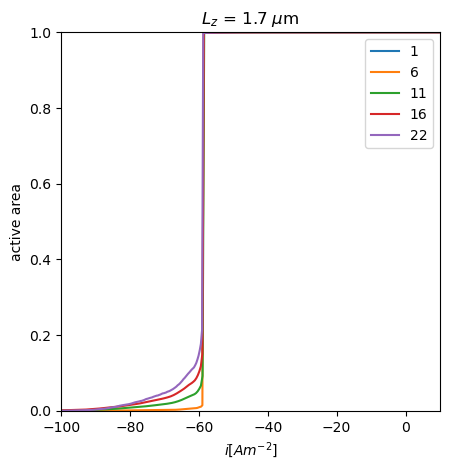

In [11]:
areas = {
    1: 100,
    6: 98.41,
    11: 36.38,
    16: 6.30,
    22: 0.45,
}

fig, ax = plt.subplots()

ul = 10
ll = -100
Lz = 1
for img_id in [1, 6, 11, 16, 22]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'], df['p_left'], label=f'{areas[img_id]} %')

ax.set_xlabel('$i [Am^{-2}]$')
ax.set_ylabel('active area')
ax.set_title(f'$L_z$ = {800/470 * Lz:.1f} $\mu$m')
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
ax.set_xlim([ll, ul])
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/study_2_cdf_{Lz}.png', dpi=1200)

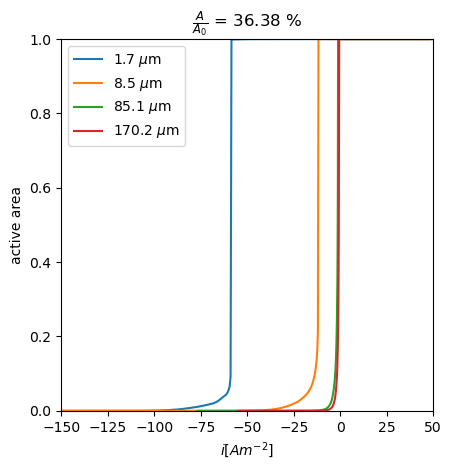

In [32]:
fig, ax = plt.subplots()

ul = 50
ll = -150
img_id = 11
for Lz in [1, 5, 50, 100]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'], df['p_left'], label=f'{800/470*Lz:.1f} $\mu$m')

ax.set_xlabel('$i [Am^{-2}]$')
ax.set_ylabel('active area')
ax.set_title(r"$\frac{A}{A_0}$ = " + f"{areas[img_id]} %")
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
ax.set_xlim([ll, ul])
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/study_2_cdf-id{img_id}.png', dpi=1200)

In [ ]:
fig, ax = plt.subplots()
img = plt.imread('/home/molel/OneDrive/PhD/Data/Current_constriction/test6.tif')
ax.imshow(img[:, :, 0])
ax.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/test6.png', dpi=1200)

In [22]:
A0 = 800e-6 ** 2  # m2
kappa = 0.1  # S/m

df = pd.read_excel('data/study_2_scaled.xlsx', sheet_name=['hi-res'])['hi-res']
df['area_fraction'] = np.around(df['area_fraction'], 4)
df['resistance [ohm]'] = (df['Lz [um]'] * 1e-6 / A0 * kappa) / df['effective_conductivity_ratio']
lengths = [1.702128, 8.5106, 85.1064, 170.2128]

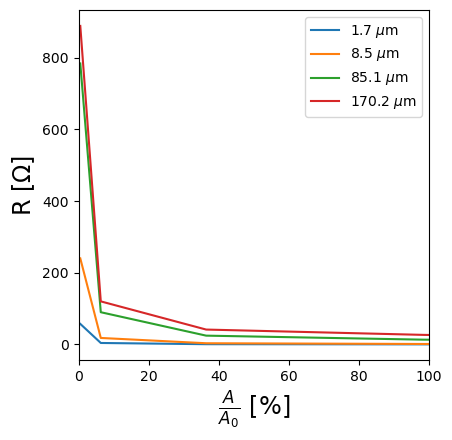

In [30]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for lz in lengths:
    df_2 = df.loc[np.isclose(df['Lz [um]'], lz), :]
    ax.plot(100 * df_2['area_fraction'], df_2['resistance [ohm]'], label=f"{lz:.1f}" + " $\mu$m")
ax.set_box_aspect(1)
ax.set_xlim([0, 100])
# ax.set_ylim([0, 1])
ax.set_xlabel(r'$\frac{A}{A_0}$ [%]', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel(r'R $[\Omega]$', fontdict={'fontsize': 'xx-large'})
ax.legend()
plt.tight_layout()
plt.savefig('figures/variable-area-comparison.png', dpi=1200)

In [12]:
area_fractions = [0.0045, 0.0630, 0.3638, 0.9841, 1.000]

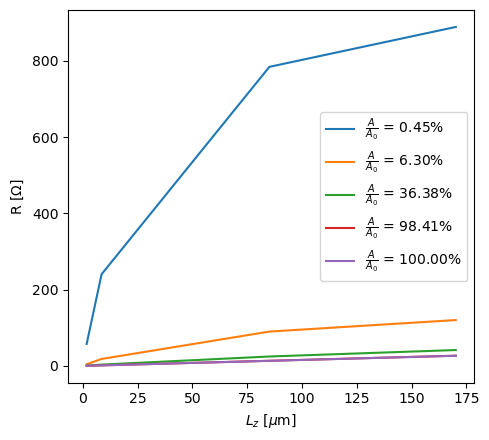

In [27]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for af in area_fractions:
    df2 = df.loc[np.isclose(df['area_fraction'], af), :]
    ax.plot(df2['Lz [um]'], df2['resistance [ohm]'], label=r"$\frac{A}{A_0}$" + f" = {100 * af:.2f}%")
ax.legend()
ax.set_xlabel(f'$L_z$ [$\mu$m]')
ax.set_ylabel(f'R [$\Omega$]')
plt.tight_layout()
plt.savefig('figures/variable-length-comparison.png', dpi=1200)

In [17]:
df.head()

,area_fraction,effective_conductivity_ratio,Lz [um],error
0,0.004504,0.004637,1.702128,4.42%
1,0.063002,0.064434,1.702128,3.18%
2,0.363770,0.368950,1.702128,1.83%
3,0.984120,0.989720,1.702128,0.28%
4,1.000000,1.004300,1.702128,0.00%
